!["Movies"](Images\movie.jpg)

# Movie Recommendation System

## Business Problem/Question

## EDA

In [57]:
# Importing packages
import numpy as np
import pandas as pd 
import math
import surprise
from surprise.prediction_algorithms import *
from surprise import KNNBaseline
from surprise import Reader
from surprise import Dataset
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree

from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score


In [65]:
pip install surprise


  Using cached surprise-0.1-py2.py3-none-any.whl (1.8 kB)


In [66]:
pip install scikit-surprise

Note: you may need to restart the kernel to use updated packages.


In [67]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [68]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


### Read in data

In [58]:
links_df = pd.read_csv('data/links.csv')
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')
tags_df = pd.read_csv('data/tags.csv')

In [59]:
ratings_df = ratings_df.drop("timestamp", axis = 1)

In [42]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB


In [44]:
ratings_df.nunique()

userId      610
movieId    9724
rating       10
dtype: int64

<AxesSubplot:xlabel='count', ylabel='Count'>

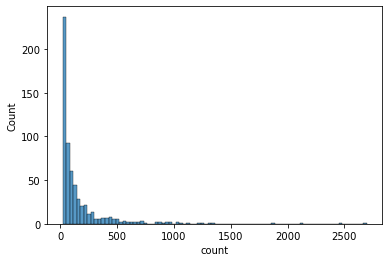

In [50]:
sns.histplot(ratings_df["userId"].value_counts())

In [52]:
superusers = ratings_df["userId"].value_counts()

In [55]:
superusers.to_csv("superusers.csv")

In [13]:
#Combine dfs to get a larger understanding of data
df = ratings_df.merge(movies_df, how="left", on="movieId")
df

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Split (2017),Drama|Horror|Thriller
100832,610,168248,5.0,1493850091,John Wick: Chapter Two (2017),Action|Crime|Thriller
100833,610,168250,5.0,1494273047,Get Out (2017),Horror
100834,610,168252,5.0,1493846352,Logan (2017),Action|Sci-Fi


In [14]:
top20 = df["movieId"].value_counts()[0:20]

In [15]:
top20 = top20.index

In [16]:
top20

Index([ 356,  318,  296,  593, 2571,  260,  480,  110,  589,  527, 2959,    1,
       1196, 2858,   50,   47,  780,  150, 1198, 4993],
      dtype='int64', name='movieId')

In [17]:
titles = df[df["movieId"].isin(top20)]

In [18]:
titles["title"].value_counts()

title
Forrest Gump (1994)                                                               329
Shawshank Redemption, The (1994)                                                  317
Pulp Fiction (1994)                                                               307
Silence of the Lambs, The (1991)                                                  279
Matrix, The (1999)                                                                278
Star Wars: Episode IV - A New Hope (1977)                                         251
Jurassic Park (1993)                                                              238
Braveheart (1995)                                                                 237
Terminator 2: Judgment Day (1991)                                                 224
Schindler's List (1993)                                                           220
Fight Club (1999)                                                                 218
Toy Story (1995)                                

## Model

In [60]:
reader = Reader(rating_scale=(1, 5))

### Missingness

Next we look at null values to try to determine which columns might need to be imputed or if the data is too incomplete to be useful. 

In [ ]:
# Looking at the total nulls left in remaining columns

df.info()

## Feature Engineering

### Feature Engineering

In [24]:
import numpy as np
import pickle
import pandas as pd
import streamlit as st


# loading the saved model
best_algo = pickle.load(open('trained_model.sav', 'rb'))
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')


In [61]:
# return the top n recommendations using the 
def recommended_movies(user_ratings,movie_title_df,n):
    full_text = ""
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        text = (str(title.values[0]) + '\n')
        full_text = full_text + text
        n-= 1
        if n == 0:
            break
    print(full_text)


In [62]:


def rate_and_rec(user_rating, ratings_df, movies_df, genre=None):
    
    ## add the new ratings to the original ratings DataFrame
    user_ratings_df = pd.DataFrame(user_rating)
    ratings_df = pd.concat([ratings_df, user_ratings_df], axis=0)
    new_data = Dataset.load_from_df(ratings_df, reader)
    best_algo = KNNBaseline(k=40, bsl_options={'method': 'sgd', 'reg': 0.02, 'n_epochs': 40})
    best_algo.fit(new_data.build_full_trainset())
    
    # make predictions for the user
    # you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
    recc_movies = []
    for m_id in ratings_df['movieId'].unique():
        prediction = best_algo.predict(1000,m_id)[3]
        recc_movies.append( (m_id, prediction) )
    
    # order the predictions from highest to lowest rated
    ranked_movies = sorted(recc_movies, key=lambda x:x[1], reverse = True)
    
    print(recommended_movies(ranked_movies,movies_df,5))

In [63]:
user_rating = [{'userId': 1000, 'movieId': 356, 'rating': 2}, 
               {'userId': 1000, 'movieId': 318, 'rating': 3},
               {'userId': 1000, 'movieId': 296, 'rating': 4}, 
               {'userId': 1000, 'movieId': 593, 'rating': 2},
               {'userId': 1000, 'movieId': 2571, 'rating': 1},              
               {'userId': 1000, 'movieId': 260, 'rating': 0}, 
               {'userId': 1000, 'movieId': 480, 'rating': 4},
               {'userId': 1000, 'movieId': 110, 'rating': 5}, 
               {'userId': 1000, 'movieId': 589, 'rating': 3},
               {'userId': 1000, 'movieId': 527, 'rating': 2}, 
               {'userId': 1000, 'movieId': 2959, 'rating': 1},
               {'userId': 1000, 'movieId': 1, 'rating': 5}, 
               {'userId': 1000, 'movieId': 1196, 'rating': 3},
               {'userId': 1000, 'movieId': 2858, 'rating': 1}, 
               {'userId': 1000, 'movieId': 50, 'rating': 0},
               {'userId': 1000, 'movieId': 47, 'rating': 4}, 
               {'userId': 1000, 'movieId': 780, 'rating': 5},
               {'userId': 1000, 'movieId': 150, 'rating': 2}, 
               {'userId': 1000, 'movieId': 1198, 'rating': 5},
               {'userId': 1000, 'movieId': 4993, 'rating': 4}]

In [64]:
recommendation = rate_and_rec(user_rating, ratings_df, movies_df, genre=None)

Estimating biases using sgd...
Computing the msd similarity matrix...


AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

## Initial Modeling

### Initial Dummy Model

#### Decide Xs/y

#### Train/Test Split

#### Modeling 

### Initial Model

#### Decide Xs/y

#### Train/Test Split

#### Preprocessing Steps (SS, OHE, SI)

#### Modeling 

## Evaluation of Initial Models

### Scores of Initial Models

## New Models

### New Model

#### Decide Xs/y

#### Train/Test Split

#### Preprocessing Steps (SS, OHE)

#### Modeling 

## Final Model Evaluations 

### Score of New Models

### Assessment